<center>
    <h1>Football field Analysis</h1>
    <b>VIC Project, Main Code</b><br>
    <i>Coded By Chloé DAEMS, Amir MAHMOUDI & Anne-Claire LAISNEY</i>
</center>

<b> Sources :</b> <br>
<i>https://link.springer.com/chapter/10.1007/978-3-540-30125-7_101</i> pp 818-824. 2004 - Use hue detection to detect grass (ie field) -- The results seems not usable for us <br>
<i> https://static1.squarespace.com/static/5b048119f2e6b103db959419/t/5e99aeb4d85a234bb8752f78/1587130062444/Learning+to+track+and+identify+players+from+broadcast+sports+videos.pdf </i> Canny Edge detector to detect the field lines <br>
<i>https://www.cse.ust.hk/~quan/comp5421/notes/canny1986.pdf</i> Paper on the Canny detector

<b>Python libraries imports</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import matplotlib.patches as patches
from skimage.morphology import *
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

**Import the image**

(350, 625)


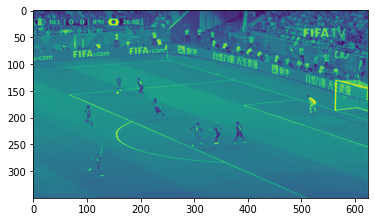

In [2]:
from skimage.transform import resize
img_input = cv2.imread("input_img1.png",cv2.IMREAD_GRAYSCALE) 
img = resize(img_input, output_shape=(350, 625))
print(img.shape)
plt.imshow(img)

## Step 1 : Canny Edge detector

**We are first going to try a step by step pipeline for image preparation and the canny edge detector, inspired by the work done in assignment 1 part 2.**

**A. Smooth the image**

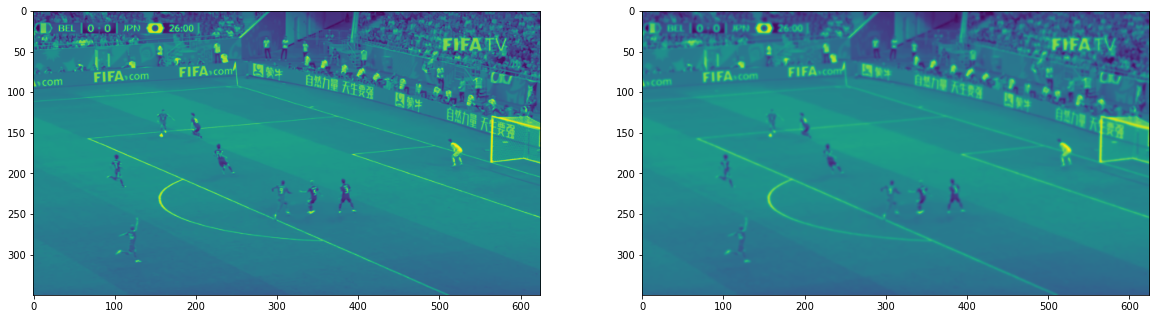

In [3]:
from scipy.ndimage import gaussian_filter
smoothed = gaussian_filter(img, sigma=1)
fig, axes = plt.subplots(figsize=(20, 12), ncols=2)
axes[0].imshow(img) 
axes[1].imshow(smoothed)

**B. Gradients**

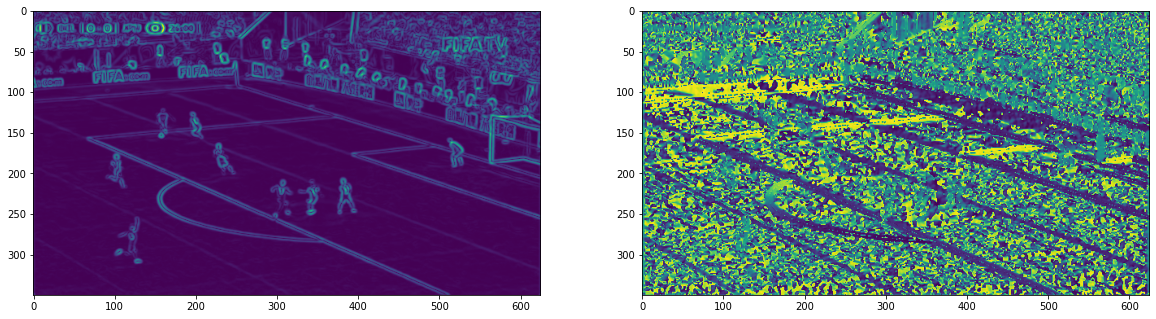

In [4]:
from skimage.filters import sobel 
def gradient(img):
    g_x = sobel(img, axis=1) 
    g_y = sobel(img, axis=0)
    g_mag = np.sqrt(g_x**2 + g_y**2) 
    g_dir = np.arctan(g_y / g_x)
    return g_mag, g_dir
fig, axes = plt.subplots(figsize=(20, 12), ncols=2) 
g_magnitude, g_dir = gradient(smoothed)
axes[0].imshow(g_magnitude) 
axes[1].imshow(g_dir)

**C. Non-maximum suppression**

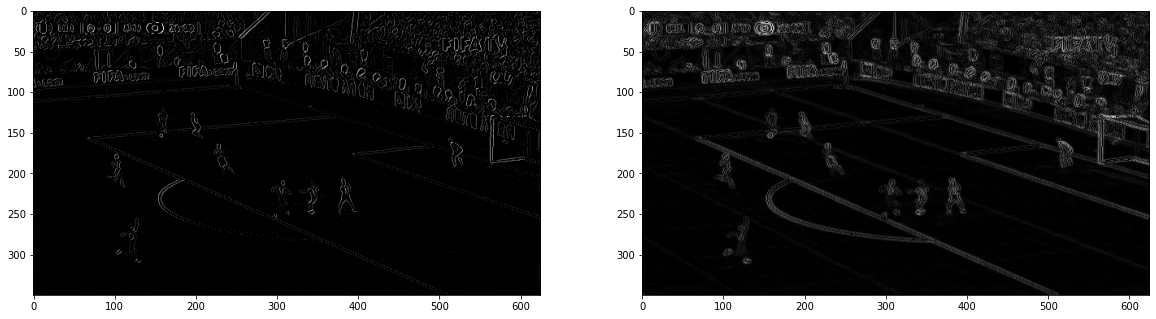

In [5]:
def non_maximum_suppression(g_magnitude, g_dir):
    #quantise the gradient directions into 4 values np.array([0, np.pi/4, np.pi/2, 3*np.pi/4])
    h, w = g_magnitude.shape 
    values = np.array([0, np.pi, np.pi/4, np.pi/2, 3*np.pi/4])
    g_max = np.zeros_like(g_magnitude)
    for i in range(h-1):
        for j in range(w-1):
            diff = abs(values - g_dir[i,j])
            angle = values[np.argmin(diff)]
            q = 0
            r = 0
            #case angle = 0
            if angle == 0 or angle == 1 :
                q = g_magnitude[i, j+1]
                r = g_magnitude[i, j-1]
            #case angle = pi/4
            elif angle == 2:
                q = g_magnitude[i+1, j-1]
                r = g_magnitude[i-1, j+1]
            #case angle = pi/2 
            elif angle == 3:
                q = g_magnitude[i+1, j]
                r = g_magnitude[i-1, j]
            #case angle = 3pi/4
            else:
                q = g_magnitude[i-1, j-1]
                r = g_magnitude[i+1, j+1]
                
            if g_magnitude[i,j] >= q and g_magnitude[i,j]>=r : 
                g_max[i,j] = g_magnitude[i,j]
            else:
                g_max[i,j] = 0

    return g_max

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

g_max = non_maximum_suppression(g_magnitude, g_dir)

axes[0].imshow(g_max, cmap='gray')
axes[1].imshow(g_magnitude - g_max, cmap='gray')

**D. Double Thresholding**

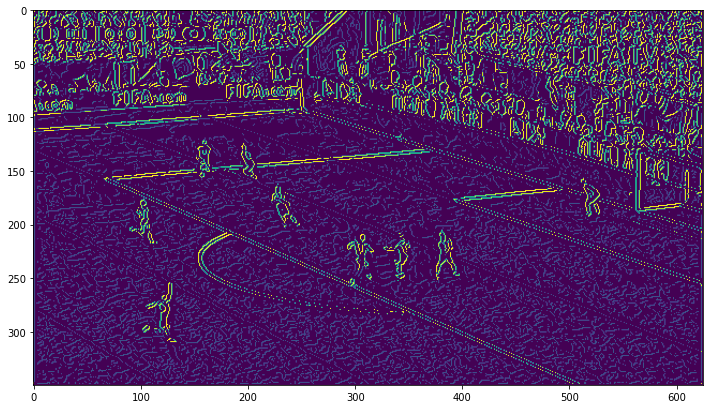

In [6]:
def double_thresholding(g_max, thresh_lo, thresh_hi):
    h, w = g_max.shape
    thresh_img = np.zeros_like(g_max)
    highThreshold = g_max.max() * thresh_hi;
    lowThreshold = highThreshold * thresh_lo;
    
    for i in range(h):
        for j in range(w):
            if g_max[i,j] > highThreshold :
                 thresh_img[i,j] = 1
            elif g_max[i,j] > lowThreshold:
                thresh_img[i,j] = 0.25

    return thresh_img

thresh_img = double_thresholding(g_max, thresh_lo=0.05, thresh_hi=0.08)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(thresh_img)

**E. Edge connectivity**

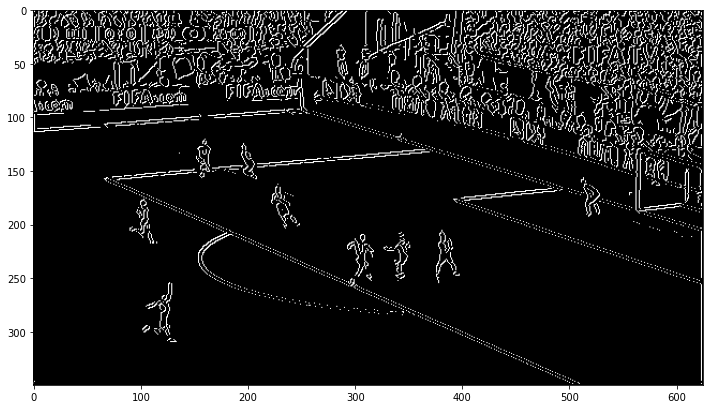

In [7]:
def connectivity(thresh_img):
    h, w = thresh_img.shape
    edge_img = thresh_img
    
    for i in range(h):
        for j in range(w):
            if edge_img[i,j] == 0.25:
                if edge_img[i+1,j] == 1 or edge_img[i+1,j+1] == 1 or edge_img[i,j+1] == 1 or edge_img[i-1,j] == 1 or edge_img[i-1,j-1] == 1 or edge_img[i,j-1] == 1 or edge_img[i+1,j-1] == 1 or edge_img[i-1,j+1] == 1:
                    edge_img[i,j] = 1 
                else:
                    edge_img[i,j] = 0

    return edge_img

edge_img = connectivity(thresh_img)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(edge_img, cmap='gray')

<div class="alert alert-block alert-success">
<b>Next step:</b> Here, you can see that the players are noising the detections of the fields'line, in the Lu's Paper they decided to detect the bounding boxes of the players to delete them from the edge detection. This is what we are going to try to do next.
</div>

### Find the players on the field
Main ref paper : http://cs.brown.edu/people/pfelzens/papers/latent.pdf (seen in course)

https://www.cs.toronto.edu/~fidler/slides/2015/CSC420/lecture19.pdf (course on DPM detector -- based on Hog detector)

we used this dataset for training :
https://drive.google.com/file/d/1ctJojwDaWtHEAeDmB-AwEcO3apqT-O-9/view?usp=sharing (SoccerPlayerDetection_bmvc17_v1 dataset)

**To remove the viewers from the image and keep only the field**

**If you want to see how we create the player detector model go the Player_detector.ipynb**

We apply our model to the image

In [8]:
#Player detection
hog = cv2.HOGDescriptor()
hog.load('myHogPlayerDector.bin')
image = cv2.imread("input_img1.png")#Screenshot from World Cup 2018 Belgique VS Japan
rects, scores = hog.detectMultiScale(image, winStride=(4, 4),padding=(8, 8), scale=1.05)

**6.2. We apply the fast Non Max Suppression**

In [9]:
#FIXME : Put it in the utils.py 
#Non-maximum suppression
def fastNonMaxSuppression(boxes, sc, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = sc
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the score of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]

In [10]:
def fastNonMaxSuppression_applied(rects,scores):
    #fastNonMaxSuppression-The first parameter
    for i in range(len(rects)):
        r = rects[i]
        rects[i][2] = r[0] + r[2]
        rects[i][3] = r[1] + r[3]

    #fastNonMaxSuppression-Second parameter
    sc = [score for score in scores]
    sc = np.array(sc)

    pick = []
    print('rects_len',len(rects))
    pick = fastNonMaxSuppression(rects, sc, overlapThresh = 0.3)
    print('pick_len = ',len(pick))

In [11]:
fastNonMaxSuppression_applied(rects,scores)

rects_len 53
pick_len =  45


In [12]:
def create_bbox(rects,scores):#we create the bounding box
    bbox = []
    for i in range(len(scores)):
        if (scores[i] > 0.3):
            bbox.append(rects[i])
    bbox = np.array(bbox)
    return bbox

In [13]:
bbox=create_bbox(rects,scores)

**6.3. We apply a color selection on the bounding boxes**

In [14]:
# Get the Main color in the bounding box and the precision
# image = an image ; colors_on_the_fild = list with all the colors to analyse (ex : ["White","Blue","Red"])
def PrimeColor(image, colors_on_the_field):
    #cv2.imshow('image',image)
    max_ratio = 0
    final_color = ""
    confidence = 0

    # FIXME : Add Cyan
    color_list = ['Blue', 'Red', 'White', 'Black', 'Yellow', 'Green', 'Purple']
    boundaries = [
        ([0, 100, 100], [10, 255, 255]),  # blue
        ([110, 50, 50], [130, 255, 255]),  # red
        ([0, 0, 213], [255, 20, 255]),  # white
        ([0, 0, 0], [10, 10, 10]),  # black
        ([80, 50, 50], [100, 255, 255]),  # yellow
        ([50, 50, 50], [70, 255, 255]),  # green
        ([140, 50, 50], [160, 255, 255]),  # purple (Magenta)
    ]

    try:
        
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        for color in colors_on_the_field:
            if color not in color_list:
                raise ValueError("This color : {}, is not yet defined in our code ... Sorry :( ".format(color))
            else:
                index = color_list.index(color)
                lower_range = np.array(boundaries[index][0])
                upper_range = np.array(boundaries[index][1])
                mask = cv2.inRange(hsv, lower_range, upper_range)

                ratio = cv2.countNonZero(mask) / np.size(mask)
                confidence += ratio
                if (ratio > max_ratio):
                    max_ratio = ratio
                    final_color = color

        try:
            conf = max_ratio / confidence
        except:
            
            final_color = "ERROR"
            conf = 0
    except:
        conf = 0
        final_color = "ERROR"
        

    return final_color, conf

In [15]:
def plot_rectangle(bbox,img,colors_on_the_field):
    fig, ax = plt.subplots(figsize=(20, 12))
    new_bbox=[]
    for x1, y1, x2, y2 in bbox:
        dx = x2 - x1
        dy = y2 - y1
        cropped_img = np.array(img[y1:y2, x1:x2])
        final_color,conf=PrimeColor(cropped_img, colors_on_the_field)
        if final_color=="ERROR":
            pass
        if final_color=="Black":
            pass
        else:
            if conf>0.7:
                new_bbox.append([x1,y1,x2,y2])
                rect = patches.Rectangle((x1, y1), dx, dy, edgecolor=final_color, facecolor='none')
                ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Prediction for frames {}')
    return new_bbox

In [16]:
def process_image(image):
    image_resize=cv2.resize(image,(512,256))
    # Converting the image to hsv
    hsv = cv2.cvtColor(image_resize, cv2.COLOR_BGR2HSV)
    
    # define range of red color in HSV
    lower_green , upper_green = np.array([25, 52, 72]), np.array([50, 255, 255])
        
    # Threshold the HSV image using inRange function to get only red colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    #using dilation gives more importance to the bright pixels (Dilation enlarges bright regions and shrinks dark regions)
    img_bg = dilation(np.invert(mask), disk(6))
    img_test = dilation(np.invert(img_bg), disk(13))
    img_input=cv2.resize(image_resize,(image.shape[1],image.shape[0]))
    res = cv2.bitwise_and(img_input,img_input, mask= cv2.resize(img_test,(image.shape[1],image.shape[0])))
    cv2.imwrite('./input_img_processed.png',np.array(res[:,:,::-1]))
    return img_test

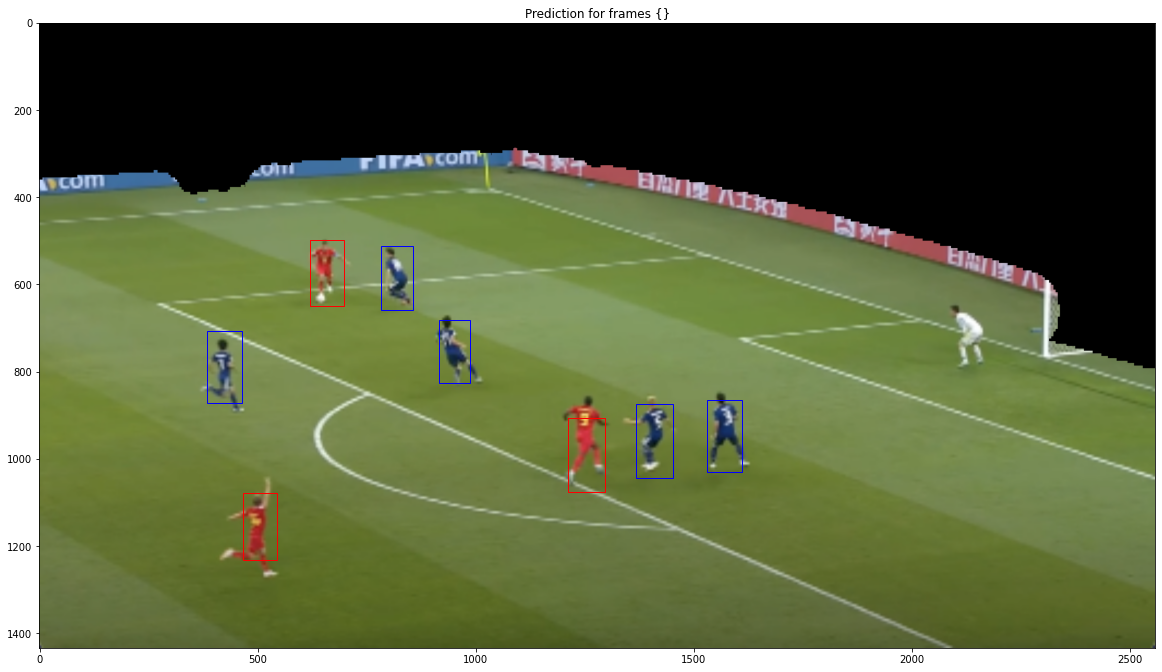

In [17]:
image = cv2.imread("input_img1.png")
colors_on_the_field=['Red', 'Blue',"Black"]
mask=process_image(image)
image = cv2.imread("./input_img_processed.png")
new_bbox=plot_rectangle(bbox,image,colors_on_the_field)

#### Canny detector Pipeline
Now we will remove the players from the fields

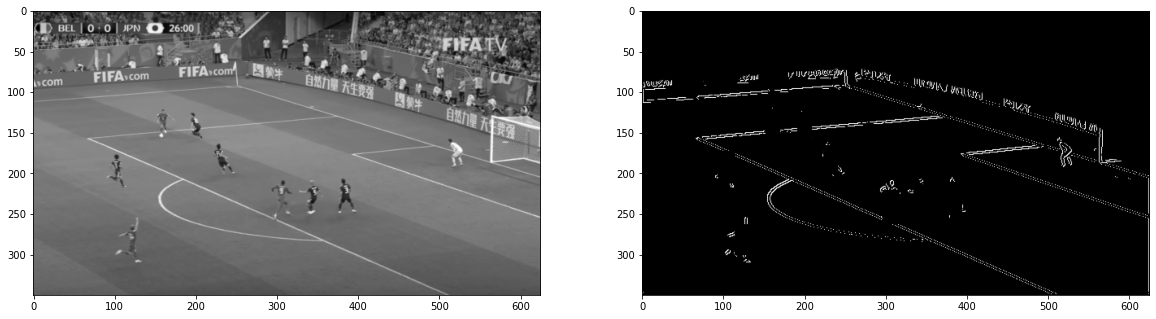

In [18]:
def canny_edge_detector(img, bbox,resize_shape,mask, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_filter(img,1)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    w,h=edge_img.shape
    edge_img=cv2.resize(edge_img,(resize_shape[1],resize_shape[0]))
    for x1, y1, x2, y2 in bbox:
        for x in range(x1,x2+1):
            for y in range(y1,y2+1):
                edge_img[y, x]=0
    # Return the result
    edge_img=cv2.resize(edge_img,(h,w))
    mask=cv2.resize(mask,(h,w))
    edge_img=edge_img*mask
    return edge_img


fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

edges = canny_edge_detector(img,new_bbox,image.shape,mask, thresh_lo=0.05, thresh_hi=0.09)

axes[0].imshow(img, cmap='gray')
axes[1].imshow(edges, cmap='gray')

We still have imperfections by the fact that the rectangles for the player detection does not include some part of the player (hands, foot, etc) This couldd be improve with further preprocessing and training of the model